In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 모듈 설치

In [ ]:
# 모델링 모듈
!pip install tensorflow-addons
!pip install neuralprophet[live]
!pip install prophet

In [ ]:
# 폰트설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 모듈 및 라이브러리

In [164]:
# 내장 라이브러리
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# 외장 라이브러리
from typing import collections, List, Tuple, Dict, DefaultDict, NewType
from collections import Counter
from datetime import datetime, timedelta
from timeit import default_timer as timer

# sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Facebook Prophet - 시계열 모델
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_yearly
# Neural Prophet - Advanced Facebook Prophet
from neuralprophet import NeuralProphet
# 시계열 모델
from statsmodels.tsa.arima_model import ARIMA
# Attention 모델
import keras
from tensorflow_addons.layers import MultiHeadAttention

In [2]:
# plot 한글
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

elif platform.system() == 'Linux': # colab 사용자의 경우에
  # 나눔고딕 폰트
  plt.rc('font', family='NanumBarunGothic') 


# 오징어 test데이터 예측

##오징어 데이터 로드

In [4]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
os.chdir('/content/drive/MyDrive/BIGCONTEST/data/real_use')

name = input('수산물 어종을 고르세요 (오징어/흰다리새우/연어)')

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

수산물 어종을 고르세요 (오징어/흰다리새우/연어)오징어


In [12]:
# train data + validation data 병합 
data = pd.concat([data, val_df])

In [13]:
# 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [14]:
# import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [15]:
train, t_len = datasetting(data, name)
#validation, v_len = datasetting(val_df, name)

In [16]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
#ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1)
ctry_list = list(set(con))

In [17]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [18]:
x_train = data_frame(train, ctry_list)

In [ ]:
#x_val = data_frame(validation, ctry_list)

## 데이터 분리

In [19]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [20]:
X_train.shape, Y_train.shape

((2109, 25), (2109,))

In [21]:
num_heads=8; head_size=32; ff_dim=None; dropout=0
multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [22]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [23]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [24]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [26]:
# 소프트맥스 함수 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [27]:
# Attention - FC layer 를 통한 가중치 리스트와 가격 리스트 생성
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [28]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [29]:
# 가중치를 이용한 새로운 가격 변수 생성
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [30]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [31]:
trn_lst = np.array([item for item in train_price if item > 0])

In [32]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])

In [33]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

## RMSE 함수 (평가지표)

In [34]:
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

- validation y : val_price


## Neural Prophet

### 하이퍼파라미터 - 각각의 Neural Prophet으로부터 최적으로 뽑아낸것

In [37]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 


In [35]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(244, 2)


In [70]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 150 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

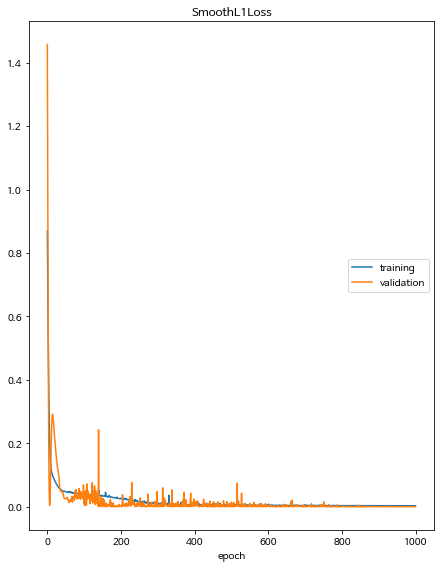

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:09<00:00, 14.35it/s, SmoothL1Loss=0.00306, MAE=0.0598, RegLoss=0.309, MAE_val=0.0146, SmoothL1Loss_val=3.95e-5]


,SmoothL1Loss,MAE,RegLoss,SmoothL1Loss_val,MAE_val
0,0.869894,2.246217,2.091118,1.457551,3.251513
1,0.710327,1.976678,2.070492,1.037671,2.554086
2,0.573245,1.743559,2.049420,0.665896,1.936565
3,0.454461,1.539740,2.028137,0.351566,1.392178
4,0.350489,1.356304,2.006585,0.155877,0.925207
...,...,...,...,...,...
995,0.003057,0.059761,0.309479,0.000040,0.014714
996,0.003057,0.059768,0.309478,0.000039,0.014580
997,0.003057,0.059759,0.309478,0.000039,0.014425
998,0.003058,0.059771,0.309477,0.000039,0.014435


In [71]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)

In [72]:
future = nprophet.make_future_dataframe(df, periods=26, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
0,2015-12-28,1.363793,1.730981,0.367188,-20.866655,-0.000027,-1.024142
1,2016-01-04,1.517730,1.731694,0.213964,-20.896168,-0.000027,-1.024142
2,2016-01-11,1.436071,1.732525,0.296454,-20.930609,-0.000027,-1.024142
3,2016-01-18,2.100804,1.733512,-0.367291,-20.971394,-0.000027,-1.024142
4,2016-01-25,2.160545,1.734740,-0.425805,-21.022175,-0.000027,-1.024142
...,...,...,...,...,...,...,...
265,2021-05-31,NaN,2.742615,NaN,-62.722206,-0.000027,-1.024142
266,2021-06-07,NaN,2.743192,NaN,-62.745987,-0.000027,-1.024142
267,2021-06-14,NaN,2.743762,NaN,-62.769760,-0.000027,-1.024142
268,2021-06-21,NaN,2.744339,NaN,-62.793533,-0.000027,-1.024142


In [73]:
pred_date = forecast.loc[forecast['ds'] > '2021-01-01', ('ds')].unique()

In [74]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in pred_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [79]:
# 오징어 최적 가격 예측 
predict_score = a['yhat1']
predict_score.values.tolist()

[2.7305450439453125,
 2.73112154006958,
 2.7316980361938477,
 2.7322747707366943,
 2.7328450679779053,
 2.733421564102173,
 2.7339982986450195,
 2.7345685958862305,
 2.735145092010498,
 2.7357215881347656,
 2.7362918853759766,
 2.736868381500244,
 2.737445116043091,
 2.7380154132843018,
 2.7385921478271484,
 2.739168643951416,
 2.7397451400756836,
 2.7403154373168945,
 2.740891933441162,
 2.741468667984009,
 2.7420389652252197,
 2.7426154613494873,
 2.743192195892334,
 2.743762493133545,
 2.7443389892578125,
 2.74491548538208]

# 흰다리새우 test 데이터 예측 

## 흰다리새우 데이터 로드 

In [106]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
os.chdir('/content/drive/MyDrive/BIGCONTEST/data/real_use')

name = input('수산물 어종을 고르세요 (오징어/흰다리새우/연어)')

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

수산물 어종을 고르세요 (오징어/흰다리새우/연어)흰다리새우


In [108]:
# train data + validation data 병합 
data = pd.concat([data, val_df])

In [109]:
# 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [110]:
# import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [111]:
train, t_len = datasetting(data, name)
#validation, v_len = datasetting(val_df, name)

In [112]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
#ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1)
ctry_list = list(set(con))

In [113]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [114]:
x_train = data_frame(train, ctry_list)

## 데이터 분리 

In [115]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [116]:
X_train.shape, Y_train.shape

((2187, 20), (2187,))

In [117]:
num_heads=8; head_size=32; ff_dim=None; dropout=0
multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [118]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [119]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [120]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [121]:
# 소프트맥스 함수 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [122]:
# Attention - FC layer 를 통한 가중치 리스트와 가격 리스트 생성
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [123]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [124]:
# 가중치를 이용한 새로운 가격 변수 생성
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [125]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [126]:
trn_lst = np.array([item for item in train_price if item > 0])

In [127]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])

In [128]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

## RMSE 함수(평가지표)

In [129]:
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

## Neural Prophet

### 하이퍼파라미터 - 각각의 Neural Prophet으로부터 최적으로 뽑아낸 것 

In [130]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 


In [131]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(247, 2)


In [132]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 30 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

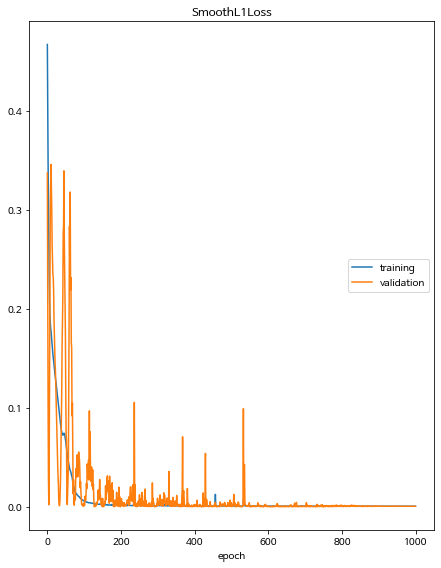

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s, SmoothL1Loss=0.000475, MAE=0.0267, RegLoss=0.000552, MAE_val=0.0677, SmoothL1Loss_val=0.000458]


,SmoothL1Loss,MAE,RegLoss,SmoothL1Loss_val,MAE_val
0,0.467280,2.273967,2.149281,0.337425,1.948494
1,0.397314,2.095715,2.132426,0.205064,1.518214
2,0.347255,1.952371,2.106719,0.103766,1.077750
3,0.305849,1.814288,2.076055,0.028307,0.553763
4,0.266341,1.659235,2.044504,0.001984,0.129314
...,...,...,...,...,...
995,0.000475,0.026734,0.000552,0.000459,0.067723
996,0.000475,0.026737,0.000552,0.000456,0.067494
997,0.000475,0.026735,0.000552,0.000458,0.067645
998,0.000475,0.026735,0.000552,0.000459,0.067707


In [133]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)

In [134]:
future = nprophet.make_future_dataframe(df, periods=26, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
0,2015-12-28,7.964061,8.554035,0.589974,8.554035,-6.368085e-08,-4.740166e-08
1,2016-01-04,7.894062,8.564285,0.670224,8.564285,-6.368085e-08,-4.740166e-08
2,2016-01-11,8.536941,8.577854,0.040913,8.577854,-6.368085e-08,-4.740166e-08
3,2016-01-18,8.760966,8.594734,-0.166232,8.594734,-6.368085e-08,-4.740166e-08
4,2016-01-25,8.704752,8.614997,-0.089755,8.614997,-6.368085e-08,-4.740166e-08
...,...,...,...,...,...,...,...
268,2021-05-31,NaN,9.803288,NaN,9.803289,-6.368085e-08,-4.740166e-08
269,2021-06-07,NaN,9.807058,NaN,9.807059,-6.368085e-08,-4.740166e-08
270,2021-06-14,NaN,9.810829,NaN,9.810829,-6.368085e-08,-4.740166e-08
271,2021-06-21,NaN,9.814598,NaN,9.814599,-6.368085e-08,-4.740166e-08


In [135]:
pred_date = forecast.loc[forecast['ds'] > '2021-01-01', ('ds')].unique()

In [136]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in pred_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [137]:
# 흰다리새우 최적 가격 예측 
predict_score = a['yhat1']
predict_score.values.tolist()

[9.72412109375,
 9.727890968322754,
 9.731660842895508,
 9.735430717468262,
 9.739200592041016,
 9.74297046661377,
 9.746740341186523,
 9.750510215759277,
 9.754280090332031,
 9.758049964904785,
 9.761819839477539,
 9.765589714050293,
 9.769359588623047,
 9.7731294631958,
 9.776899337768555,
 9.780669212341309,
 9.784439086914062,
 9.788208961486816,
 9.79197883605957,
 9.795748710632324,
 9.799518585205078,
 9.803288459777832,
 9.807058334350586,
 9.810829162597656,
 9.814598083496094,
 9.818368911743164]

In [138]:
a[['ds','yhat1']]

,ds,yhat1
0,2021-01-04,9.724121
1,2021-01-11,9.727891
2,2021-01-18,9.731661
3,2021-01-25,9.735431
4,2021-02-01,9.739201
5,2021-02-08,9.742970
6,2021-02-15,9.746740
7,2021-02-22,9.750510
8,2021-03-01,9.754280
9,2021-03-08,9.758050


# 연어 test데이터 예측 

## 연어 데이터 로드 

In [139]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
os.chdir('/content/drive/MyDrive/BIGCONTEST/data/real_use')

name = input('수산물 어종을 고르세요 (오징어/흰다리새우/연어)')

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

수산물 어종을 고르세요 (오징어/흰다리새우/연어)연어


In [140]:
# train data + validation data 병합 
data = pd.concat([data, val_df])

In [141]:
# 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [142]:
# import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [143]:
train, t_len = datasetting(data, name)
#validation, v_len = datasetting(val_df, name)

In [144]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
#ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1)
ctry_list = list(set(con))

In [145]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [146]:
x_train = data_frame(train, ctry_list)

## 데이터 분리

In [147]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [148]:
X_train.shape, Y_train.shape

((664, 14), (664,))

In [149]:
num_heads=8; head_size=32; ff_dim=None; dropout=0
multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [150]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [151]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [152]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [153]:
# 소프트맥스 함수 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [154]:
# Attention - FC layer 를 통한 가중치 리스트와 가격 리스트 생성
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [155]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [156]:
# 가중치를 이용한 새로운 가격 변수 생성
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [157]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [158]:
trn_lst = np.array([item for item in train_price if item > 0])

In [159]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])

In [160]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

## RMSE 함수(평가지표)

In [161]:
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

## Facebook Prophet 

In [162]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 


In [163]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(247, 2)


In [189]:
# Facebook Prophet 모델 개체 생성 
m = Prophet(changepoint_prior_scale = 0.03)

In [190]:
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [191]:
future = m.make_future_dataframe(periods=26, freq='W-MON')
forecast = m.predict(future)  

In [192]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-28,8.884821,8.808741,8.897760,8.884821,8.884821,-0.032163,-0.032163,-0.032163,-0.032163,-0.032163,-0.032163,0.0,0.0,0.0,8.852658
1,2016-01-04,8.926507,8.878749,8.966664,8.926507,8.926507,-0.005367,-0.005367,-0.005367,-0.005367,-0.005367,-0.005367,0.0,0.0,0.0,8.921140
2,2016-01-11,8.968192,8.929697,9.018769,8.968192,8.968192,0.008530,0.008530,0.008530,0.008530,0.008530,0.008530,0.0,0.0,0.0,8.976722
3,2016-01-18,9.009877,8.968021,9.056468,9.009877,9.009877,0.004081,0.004081,0.004081,0.004081,0.004081,0.004081,0.0,0.0,0.0,9.013958
4,2016-01-25,9.051563,8.996491,9.085314,9.051563,9.051563,-0.011131,-0.011131,-0.011131,-0.011131,-0.011131,-0.011131,0.0,0.0,0.0,9.040431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2021-05-31,9.758787,9.662026,9.901588,9.637370,9.852819,0.031928,0.031928,0.031928,0.031928,0.031928,0.031928,0.0,0.0,0.0,9.790715
269,2021-06-07,9.755382,9.659235,9.906799,9.625121,9.856733,0.035666,0.035666,0.035666,0.035666,0.035666,0.035666,0.0,0.0,0.0,9.791048
270,2021-06-14,9.751978,9.642607,9.900950,9.613469,9.861987,0.037580,0.037580,0.037580,0.037580,0.037580,0.037580,0.0,0.0,0.0,9.789558
271,2021-06-21,9.748573,9.631830,9.919775,9.602977,9.865670,0.037150,0.037150,0.037150,0.037150,0.037150,0.037150,0.0,0.0,0.0,9.785723


In [193]:
pred_date = forecast.loc[forecast['ds'] > '2021-01-01', ('ds')].unique()

In [194]:
a = pd.DataFrame(columns=['ds','yhat'])
for i in pred_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i,('ds','yhat')].index])
a.reset_index(drop=True, inplace = True)

In [195]:
a[['ds','yhat']]

,ds,yhat
0,2021-01-04,9.827232
1,2021-01-11,9.835774
2,2021-01-18,9.826217
3,2021-01-25,9.807223
4,2021-02-01,9.791335
5,2021-02-08,9.784604
6,2021-02-15,9.784362
7,2021-02-22,9.785067
8,2021-03-01,9.784374
9,2021-03-08,9.783618
